# Import Library

In [ ]:
!pip install opendatasets

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import opendatasets as od

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.layers import Dense, LSTM

# Load Data

In [ ]:
od.download('https://www.kaggle.com/datasets/fedesoriano/traffic-prediction-dataset/data')

Skipping, found downloaded files in "./traffic-prediction-dataset" (use force=True to force download)


In [ ]:
df = pd.read_csv('/content/traffic-prediction-dataset/traffic.csv')

df

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041
...,...,...,...,...
48115,2017-06-30 19:00:00,4,11,20170630194
48116,2017-06-30 20:00:00,4,30,20170630204
48117,2017-06-30 21:00:00,4,16,20170630214
48118,2017-06-30 22:00:00,4,22,20170630224


# Preprocessing Data

In [ ]:
df['DateTime'] = pd.to_datetime(df['DateTime'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
 3   ID        48120 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.5 MB


In [ ]:
avg = df.groupby(by='DateTime').agg({
    'Vehicles': 'mean'
}).rename(columns={'Vehicles': 'Average'}).reset_index()

avg

,DateTime,Average
0,2015-11-01 00:00:00,10.000000
1,2015-11-01 01:00:00,8.666667
2,2015-11-01 02:00:00,6.666667
3,2015-11-01 03:00:00,4.666667
4,2015-11-01 04:00:00,6.000000
...,...,...
14587,2017-06-30 19:00:00,45.750000
14588,2017-06-30 20:00:00,48.000000
14589,2017-06-30 21:00:00,41.250000
14590,2017-06-30 22:00:00,40.250000


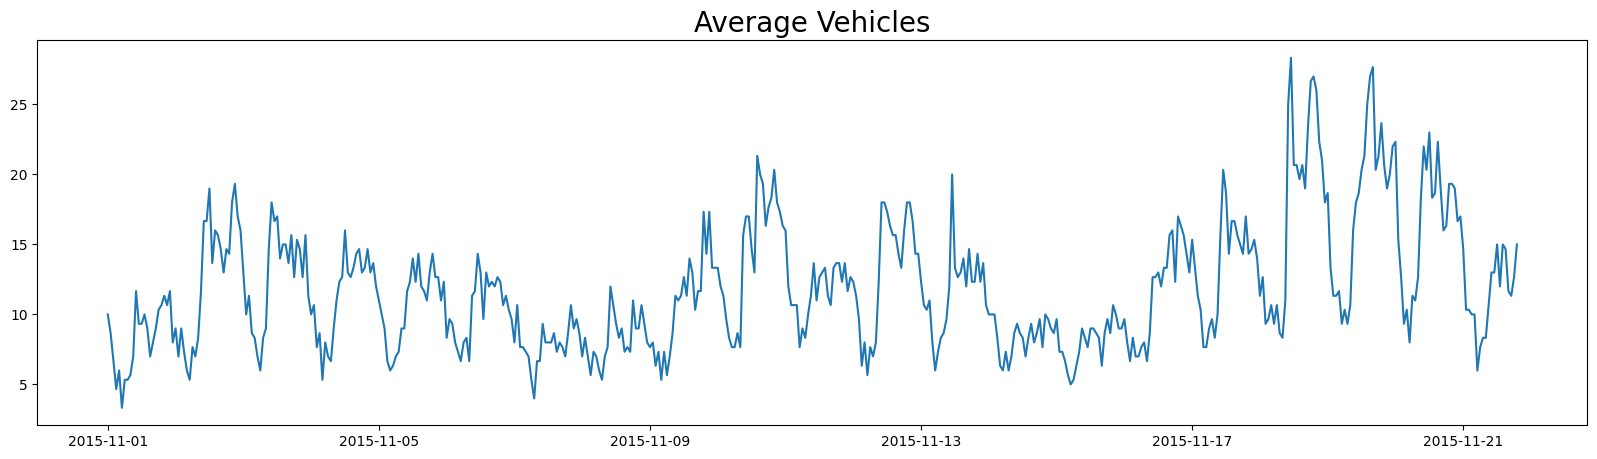

In [ ]:
dates = avg['DateTime'].values
vehicles = avg['Average'].values

plt.figure(figsize=(20,5))
plt.plot(dates[:500], vehicles[:500])
plt.title('Average Vehicles', fontsize=20)
plt.show()

### Normalization

In [ ]:
dates = dates.reshape(-1, 1)

standard_scaler = StandardScaler()
standard_scaler.fit(dates)
scaled_data = standard_scaler.transform(dates)

### Split Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(scaled_data, vehicles, test_size=0.3, shuffle=False)

In [ ]:
print(len(X_train))
print(len(X_test))

10214
4378


# Model

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
train_set = windowed_dataset(y_train, window_size=60, batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(y_test, window_size=60, batch_size=100, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Bidirectional(LSTM(64)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1),
])

In [114]:
threshold_mae = (avg['Average'].max() - avg['Average'].min()) * 10/100

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < threshold_mae and logs.get('val_mae') < threshold_mae):
      print("\nMAE telah mencapai < 10% skala data!")
      self.model.stop_training= True

callbacks = myCallback()

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [ ]:
history = model.fit(
    train_set,
    epochs=150,
    validation_data=test_set,
    verbose=2,
    callbacks=[callbacks]
)

Epoch 1/150
102/102 - 22s - loss: 19.3114 - mae: 19.8114 - val_loss: 26.7765 - val_mae: 27.2765 - 22s/epoch - 219ms/step
Epoch 2/150
102/102 - 3s - loss: 18.5449 - mae: 19.0449 - val_loss: 25.6685 - val_mae: 26.1685 - 3s/epoch - 31ms/step
Epoch 3/150
102/102 - 4s - loss: 16.6145 - mae: 17.1145 - val_loss: 21.9394 - val_mae: 22.4394 - 4s/epoch - 37ms/step
Epoch 4/150
102/102 - 5s - loss: 9.6911 - mae: 10.1780 - val_loss: 9.6373 - val_mae: 10.1253 - 5s/epoch - 49ms/step
Epoch 5/150
102/102 - 4s - loss: 9.0226 - mae: 9.5128 - val_loss: 9.1826 - val_mae: 9.6700 - 4s/epoch - 38ms/step
Epoch 6/150
102/102 - 3s - loss: 8.8344 - mae: 9.3243 - val_loss: 9.1084 - val_mae: 9.5956 - 3s/epoch - 31ms/step
Epoch 7/150
102/102 - 4s - loss: 8.6912 - mae: 9.1808 - val_loss: 8.9242 - val_mae: 9.4104 - 4s/epoch - 36ms/step
Epoch 8/150
102/102 - 4s - loss: 8.5322 - mae: 9.0214 - val_loss: 8.7270 - val_mae: 9.2128 - 4s/epoch - 37ms/step
Epoch 9/150
102/102 - 3s - loss: 8.4012 - mae: 8.8903 - val_loss: 8.626

# Plot

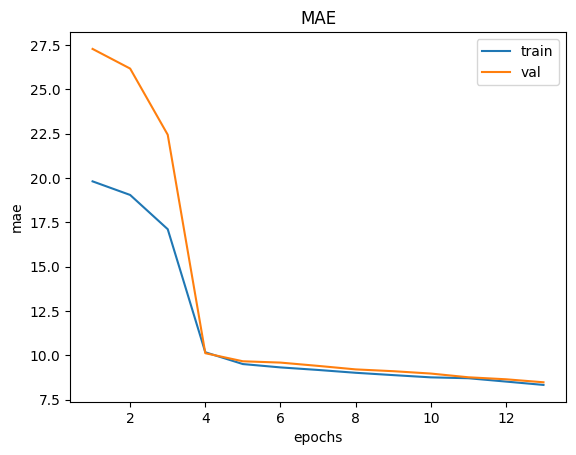

In [ ]:
training_mae = history.history['mae']
validation_mae = history.history['val_mae']
epochs = range(1, len(training_mae) + 1)

plt.plot(epochs, training_mae, label='train')
plt.plot(epochs, validation_mae, label='val')
plt.title('MAE')
plt.xlabel('epochs')
plt.ylabel('mae')
plt.legend()
plt.show()

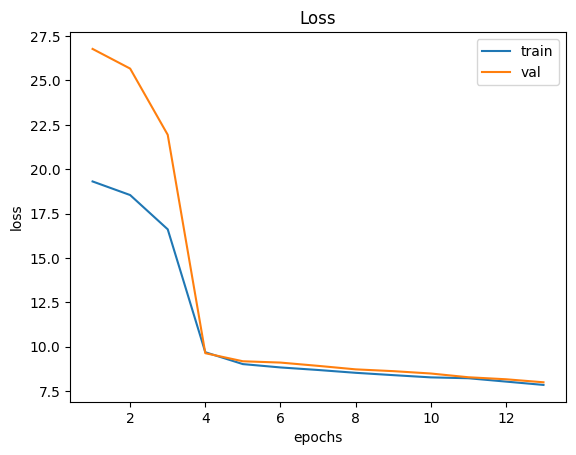

In [ ]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.plot(epochs, training_loss, label='train')
plt.plot(epochs, validation_loss, label='val')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()